In [1]:
import os
from os import path
import sys
import math
import cv2 # Read raw image
import glob
import random
import numpy as np
import pickle
from matplotlib import pyplot as plt
from scipy import ndimage # For rotation task or
import imutils
from skimage.color import rgb2lab, lab2rgb, rgb2gray
from skimage.io import imsave
from skimage.transform import resize
from sklearn.neighbors import NearestNeighbors
from pprint import pprint
from tqdm import tqdm, tqdm_notebook

import tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.utils import data_utils
from tensorflow.keras.preprocessing.image import Iterator
from tensorflow.keras import Input
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, AveragePooling2D, MaxPooling2D, Reshape, Conv2DTranspose, ZeroPadding2D, Add
from tensorflow.keras.layers import Activation, InputLayer, BatchNormalization
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.layers import PReLU


# Check to see if GPU is being used
print(tensorflow.test.gpu_device_name())
print("Num GPUs Available: ", tf.config.experimental.list_physical_devices('GPU'))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

/device:GPU:0
Num GPUs Available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
Num GPUs Available:  2


In [2]:
# DATA_PATH = "/home/satyarth934/data/modis_data_products/*/array_3bands_normalized/448/*"
# DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/mean_stdev_removed/*" # <- needs to be normalized
DATA_PATH = "/home/satyarth934/data/modis_data_products/terra/array_3bands_adapted/448/median_removed/*" # <- needs to be normalized
MODEL_NAME = "baseAE_median"
BASE_DIR = "/home/satyarth934/code/FDL_2020/"
NORMALIZE = True
SAVE_FILES = False

OUTPUT_MODEL_PATH = BASE_DIR + "Models/" + MODEL_NAME
TENSORBOARD_LOG_DIR = BASE_DIR + "tb_logs/" + MODEL_NAME
ACTIVATION_IMG_PATH = BASE_DIR + "activation_viz/" + MODEL_NAME
PATH_LIST = BASE_DIR + "Features/" + MODEL_NAME + "_filenames.pkl"
FEATURES_OUTPUT = BASE_DIR + "Features/" + MODEL_NAME + "_features.pkl"

NUM_EPOCHS = 200

In [3]:
X_test_paths = pickle.load(file=open((PATH_LIST), 'rb'))
feature_list = pickle.load(file=open((FEATURES_OUTPUT), 'rb'))

In [4]:
num_images = len(X_test_paths)
num_features_per_image = len(feature_list[0])
print("Number of images = ", num_images)
print("Number of features per image = ", num_features_per_image)

Number of images =  73
Number of features per image =  602112


In [5]:
# Use scikit-learn to find Nearest Neighbors
neighbors = NearestNeighbors(n_neighbors=50,
                             algorithm='brute',
                             metric='euclidean').fit(feature_list)


In [14]:
# Visually checking the images
random_index = 25
# KNN distance to all the neighbors with the reference image
distances, indices = neighbors.kneighbors([feature_list[random_index]])

sorted_idx = np.argsort(distances[0])        # sorting the index to get the image with min distance

# Similar
similar_idxs = sorted_idx[:10]
print("Similar")
print(distances[0][similar_idxs])         # index of interest
print(indices[0][similar_idxs])           # the selected distances

# Dissimilar
dissimilar_idxs = sorted_idx[-1:-10:-1]
print("Dissimilar")
print(distances[0][dissimilar_idxs])         # index of interest
print(indices[0][dissimilar_idxs])           # the selected distances

Similar
[4.1589993e-07 3.1791985e-01 3.3535343e-01 3.8596275e-01 5.1297545e-01
 5.1341331e-01 5.1404923e-01 5.1886791e-01 5.2170646e-01 5.2363724e-01]
[25 35 52 31 12 70 46 40 68 55]
Dissimilar
[0.6909478  0.6907436  0.68551034 0.68262076 0.67761225 0.6705855
 0.6564066  0.6352605  0.6327267 ]
[53 44 72 50 61 24  5 54 18]


In [15]:
# Normalize the image to plot
def normalize(mat):
#     valid_cells = np.invert(np.isnan(mat))
#     normalized = np.subtract(mat, np.nanmin(mat), where=valid_cells) / (np.nanmax(mat) - np.nanmin(mat))
    normalized = (mat - np.nanmin(mat)) / (np.nanmax(mat) - np.nanmin(mat))
    return normalized

First image is the Query Image
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0
img.shape: (448, 448, 3) min: 0.0 max: 1.0


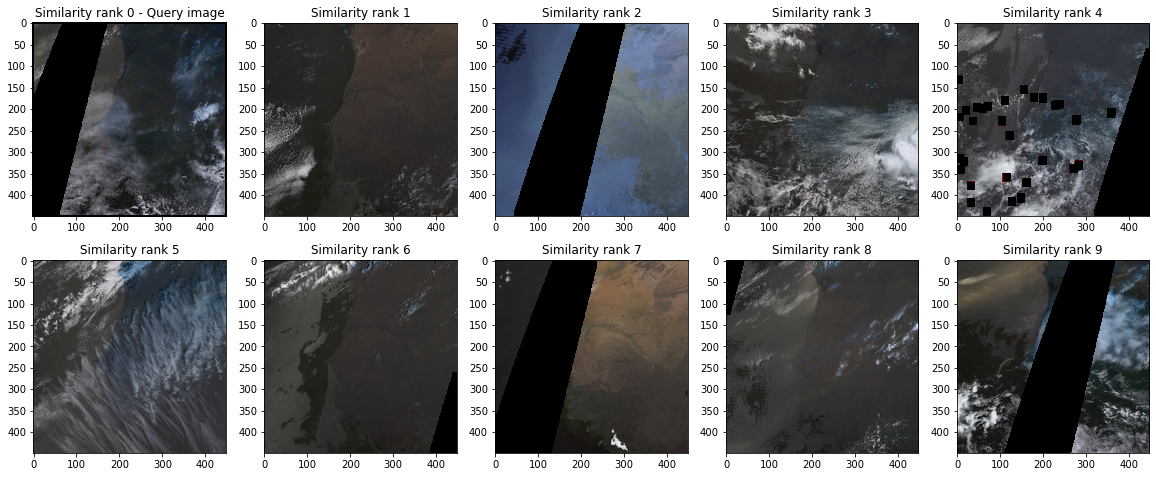

In [16]:
# SIMILAR IMAGES

img_idx = [random_index, *similar_idxs]
filenames_selected = [X_test_paths[i] for i in img_idx]

r = 2; c = 5
fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r))

# Query Image
print("First image is the Query Image")
for i, filename in enumerate(filenames_selected):
    if NORMALIZE:
        img = normalize(np.load(filename))
    else:
        img = np.load(filename)
        
    try:
        if (i/c == 0 and i%c == 0): # Query Image is marked
            axs[int(i/c), i%c].set_title('Similarity rank %d - Query image' % (i))
            for axis in ['top','bottom','left','right']:
                axs[int(i/c), i%c].spines[axis].set_linewidth(2)
        else:
            axs[int(i/c), i%c].set_title('Similarity rank %d' % (i))
            
        axs[int(i/c), i%c].imshow(img, interpolation='lanczos')
    except:
        continue

if SAVE_FILES:
    fig.savefig(BASE_DIR + "Features/" + MODEL_NAME + "_similar.png")

First image is the Query Image
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0
min: 0.0 max: 1.0


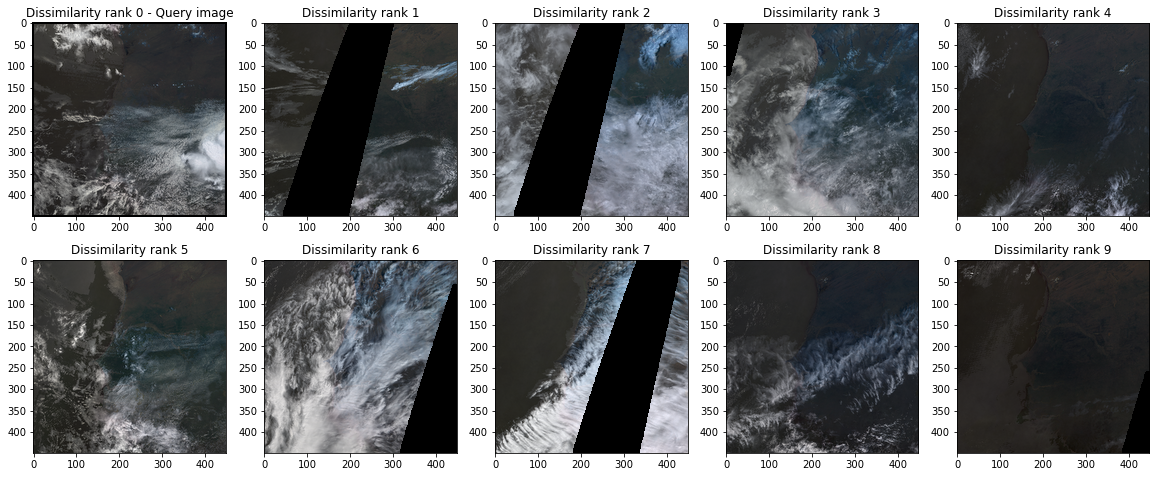

In [9]:
# DISSIMILAR IMAGES

img_idx = [random_index, *dissimilar_idxs]
filenames_selected = [X_test_paths[i] for i in img_idx]

r = 2; c = 5
fig, axs = plt.subplots(nrows=r, ncols=c, figsize=(4*c,4*r))

# Query Image
print("First image is the Query Image")
for i, filename in enumerate(filenames_selected):
    if NORMALIZE:
        img = normalize(np.load(filename))
    else:
        img = np.load(filename)
    print("min:", np.nanmin(img), "max:", np.nanmax(img))
    
    try:
        if (i/c == 0 and i%c == 0):
            axs[int(i/c), i%c].set_title('Dissimilarity rank %d - Query image' % (i))
            for axis in ['top','bottom','left','right']:
                axs[int(i/c), i%c].spines[axis].set_linewidth(2)
        else:
            axs[int(i/c), i%c].set_title('Dissimilarity rank %d' % (i))
            
        axs[int(i/c), i%c].imshow(img, interpolation='lanczos')
    except:
        continue

if SAVE_FILES:
    fig.savefig(BASE_DIR + "Features/" + MODEL_NAME + "_dissimilar.png")